In [2]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# !ls /content/gdrive/MyDrive

In [5]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

In [6]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [7]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:00<00:00, 160MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 3.
Label code corresponds to LYM class.


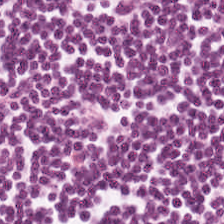

In [8]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

In [13]:
class Model:

    def __init__(self):
        self.input_shape = (224, 224, 3)
        self.model = self.build_model()

    def build_model(self):
        base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=self.input_shape)
        model = Sequential()
        model.add(base_model)
        model.add(GlobalAveragePooling2D(input_shape=self.input_shape))
        model.add(Dense(9, activation='softmax'))
        return model


    def save(self, name: str):
        self.model.save(f'{name}.h5')

    def load(self, name: str):
        name_to_id_dict = {
            'best_last':'1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe',
            'best_small':'1-1vjd0EnRRTKug_ptDAyJhW_gDpJF6aA',
            'best_tiny':'1EEgqjrlZCfwU-f38867n0Gcst521ji-8'
        }
        link = f"https://drive.google.com/uc?export=download&id={name_to_id_dict.get(name, '')}"
        gdown.download(link, f'{name}.h5', quiet=False)
        self.model.load_weights(f'{name}.h5')

    def train(self, dataset: Dataset):
        print(f'training started')
        self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(dataset.images, dataset.labels, epochs=10, batch_size=64)
        print(f'training done')

    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for i in tqdm(range(n)):
            img, label = dataset.image_with_label(i)
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        prediction = self.model.predict(np.expand_dims(img, axis=0))[0]
        return np.argmax(prediction)

In [10]:
d_train_tiny = Dataset('train_tiny')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:03<00:00, 27.5MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.


In [11]:
model = Model()
model.train(d_train_tiny)
model.save('/content/gdrive/My Drive/Colab Notebooks/best_tiny')

51877672/51877672 [==============================] - 4s 0us/step
training started
Epoch 1/10
15/15 [==============================] - 113s 986ms/step - loss: 0.7098 - accuracy: 0.7689
Epoch 2/10
15/15 [==============================] - 11s 757ms/step - loss: 0.3939 - accuracy: 0.8667
Epoch 3/10
15/15 [==============================] - 11s 763ms/step - loss: 0.5538 - accuracy: 0.8467
Epoch 4/10
15/15 [==============================] - 12s 771ms/step - loss: 0.3335 - accuracy: 0.8978
Epoch 5/10
15/15 [==============================] - 12s 779ms/step - loss: 0.2790 - accuracy: 0.9167
Epoch 6/10
15/15 [==============================] - 12s 779ms/step - loss: 0.2943 - accuracy: 0.8944
Epoch 7/10
15/15 [==============================] - 12s 777ms/step - loss: 0.2529 - accuracy: 0.9233
Epoch 8/10
15/15 [==============================] - 12s 773ms/step - loss: 0.1955 - accuracy: 0.9411
Epoch 9/10
15/15 [==============================] - 12s 767ms/step - loss: 0.2262 - accuracy: 0.9378
Epoch 10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
d_train_small = Dataset('train_small')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR
To: /content/train_small.npz
100%|██████████| 841M/841M [00:20<00:00, 41.0MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


In [14]:
model = Model()
model.load('best_tiny')
model.train(d_train_small)
model.save('/content/gdrive/My Drive/Colab Notebooks/best_small')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1EEgqjrlZCfwU-f38867n0Gcst521ji-8
From (redirected): https://drive.google.com/uc?export=download&id=1EEgqjrlZCfwU-f38867n0Gcst521ji-8&confirm=t&uuid=fb7be60e-861d-4e49-a216-1b4d76d1adc8
To: /content/best_tiny.h5
100%|██████████| 153M/153M [00:00<00:00, 155MB/s]


training started
Epoch 1/10
113/113 [==============================] - 180s 879ms/step - loss: 0.2986 - accuracy: 0.9076
Epoch 2/10
113/113 [==============================] - 93s 819ms/step - loss: 0.1761 - accuracy: 0.9485
Epoch 3/10
113/113 [==============================] - 92s 818ms/step - loss: 0.1106 - accuracy: 0.9643
Epoch 4/10
113/113 [==============================] - 92s 818ms/step - loss: 0.1216 - accuracy: 0.9625
Epoch 5/10
113/113 [==============================] - 92s 818ms/step - loss: 0.0748 - accuracy: 0.9768
Epoch 6/10
113/113 [==============================] - 92s 818ms/step - loss: 0.1047 - accuracy: 0.9667
Epoch 7/10
113/113 [==============================] - 92s 818ms/step - loss: 0.0625 - accuracy: 0.9801
Epoch 8/10
113/113 [==============================] - 92s 816ms/step - loss: 0.0422 - accuracy: 0.9864
Epoch 9/10
113/113 [==============================] - 92s 817ms/step - loss: 0.0490 - accuracy: 0.9857
Epoch 10/10
113/113 [==============================] - 

In [11]:
d_train = Dataset('train')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi
To: /content/train.npz
100%|██████████| 2.10G/2.10G [00:52<00:00, 39.7MB/s]


Loading dataset train from npz.
Done. Dataset train consists of 18000 images.


In [12]:
model = Model()
model.load('best_small')
model.train(d_train)
model.save('/content/gdrive/My Drive/Colab Notebooks/best_last')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-1vjd0EnRRTKug_ptDAyJhW_gDpJF6aA
From (redirected): https://drive.google.com/uc?export=download&id=1-1vjd0EnRRTKug_ptDAyJhW_gDpJF6aA&confirm=t&uuid=b5116d5a-ac5c-4b22-8282-787d7275fed6
To: /content/best_small.h5
100%|██████████| 153M/153M [00:00<00:00, 217MB/s]


training started
Epoch 1/10
282/282 [==============================] - 339s 835ms/step - loss: 0.0886 - accuracy: 0.9725
Epoch 2/10
282/282 [==============================] - 231s 818ms/step - loss: 0.0872 - accuracy: 0.9723
Epoch 3/10
282/282 [==============================] - 230s 817ms/step - loss: 0.0512 - accuracy: 0.9831
Epoch 4/10
282/282 [==============================] - 231s 818ms/step - loss: 0.0502 - accuracy: 0.9837
Epoch 5/10
282/282 [==============================] - 230s 817ms/step - loss: 0.0472 - accuracy: 0.9851
Epoch 6/10
282/282 [==============================] - 230s 816ms/step - loss: 0.0312 - accuracy: 0.9889
Epoch 7/10
282/282 [==============================] - 230s 817ms/step - loss: 0.0363 - accuracy: 0.9881
Epoch 8/10
282/282 [==============================] - 230s 816ms/step - loss: 0.0259 - accuracy: 0.9917
Epoch 9/10
282/282 [==============================] - 230s 817ms/step - loss: 0.0268 - accuracy: 0.9908
Epoch 10/10
282/282 [==========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
model = Model()
model.load('best_last')

d_test = Dataset('test')
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe
From (redirected): https://drive.google.com/uc?export=download&id=1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe&confirm=t&uuid=5fdf6429-79e7-4c7e-88d4-f0ee98185b52
To: /content/best_last.h5
100%|██████████| 153M/153M [00:01<00:00, 151MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:12<00:00, 42.8MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


  0%|          | 0/450 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step
metrics for 10% of test:
	 accuracy 0.9844:
	 balanced accuracy 0.9844:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [15]:
model = Model()
model.load('best_last')

if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe
From (redirected): https://drive.google.com/uc?export=download&id=1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe&confirm=t&uuid=2c13da04-a59d-47e6-9ccb-c7bc13c1db36
To: /content/best_last.h5
100%|██████████| 153M/153M [00:00<00:00, 156MB/s]


  0%|          | 0/4500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
metrics for test:
	 accuracy 0.9324:
	 balanced accuracy 0.9324:


In [16]:
final_model = Model()
final_model.load('best_last')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe
From (redirected): https://drive.google.com/uc?export=download&id=1-3Ov6JW87ho9Zfk7KKc5NeFgINLMfxHe&confirm=t&uuid=df5777cf-d4a5-4616-8d90-bc50ad520474
To: /content/best_last.h5
100%|██████████| 153M/153M [00:01<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 18.0MB/s]

Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


  0%|          | 0/90 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step
metrics for test-tiny:
	 accuracy 0.9556:
	 balanced accuracy 0.9556:


In [17]:
drive.flush_and_unmount()